In [1]:
# Install required packages
# pip install langgraph langchain-google-genai

import os
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from dotenv import load_dotenv

In [9]:
import os
from pathlib import Path

def load_all_txt_files(directory_path):
    """
    Load all .txt files from a directory into a single large string.
    
    Args:
        directory_path: Path to the directory containing .txt files
    
    Returns:
        A single string containing all text file contents
    """
    combined_string = ""
    
    # Get all .txt files from the directory
    txt_files = sorted(Path(directory_path).glob("*.txt"))
    
    # Read each file and append to the combined string
    for txt_file in txt_files:
        try:
            with open(txt_file, 'r', encoding='utf-8') as file:
                content = file.read()
                combined_string += content
                # Optional: Add separator between files
                # combined_string += "\n\n---\n\n"
        except Exception as e:
            print(f"Error reading {txt_file}: {e}")
    
    return combined_string

# Example usage
directory = "src/data/parsedMemories"  # Current directory, or specify your path
result = load_all_txt_files(directory)
print(f"Total characters loaded: {len(result)}")
print(f"First 100 characters: {result[:100]}")


Total characters loaded: 2349
First 100 characters: Image_UID: picture1
People: Tippi Hedren
Year: 
Event: 
Story: 
Image_UID: picture10
People: Melanie


In [11]:
def load_textfile_as_string(file_path):
    """
    Load a text file and return its contents as a string.
    
    Args:
        file_path: Path to the text file
    
    Returns:
        String containing the file contents
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

text = load_textfile_as_string("src/data/facts.txt")
print(text)

Tippi Hedren (Nathalie Kay Hedren) is 95 years old, born on January 19 1930 in New Ulm, Minnesota. They work as actress, model, animal rights activist. Their first favorite film was Gone with the Wind (1939), and their favorite starring role was "Marnie". Their favorite leading man is Sean Connery. They have a fear of spiders, and their favorite color is red.


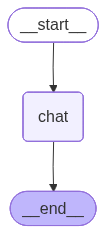

In [12]:
from langchain_core.messages import SystemMessage

# Set your API key
load_dotenv(".env")

# Set your API key
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

# Define the state
class ChatState(TypedDict):
    """The state of the chat."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Initialize Gemini model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    temperature=0.7,
    max_retries=2,
)

# Define the chat node
# Add a system message here. Two options:

# Option A (recommended): define a SystemMessage constant and prepend it inside chat_node
SYSTEM_MESSAGE = SystemMessage(content="You are a helpful assistant that answers concisely. Your user is " + load_textfile_as_string("src/data/facts.txt") + " Here is the additional memories about your user:" + load_all_txt_files(directory))

# Then modify chat_node to use:
#   messages = [SYSTEM_MESSAGE] + list(state["messages"])
#   response = llm.invoke(messages)

# Option B: include the system message when launching the graph (CELL INDEX 2):
#   inputs = {"messages": [SYSTEM_MESSAGE, HumanMessage(content="Hello! Tell me about LangGraph.")]}
def chat_node(state: ChatState):
    """Process messages with Gemini."""
    messages = [SYSTEM_MESSAGE] + list(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

# Create the graph
workflow = StateGraph(ChatState)

# Add the chat node
workflow.add_node("chat", chat_node)

# Set entry point and edges
workflow.set_entry_point("chat")
workflow.add_edge("chat", END)

# Compile the graph
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
from langchain_core.messages import HumanMessage

# Run the graph with user input and conversation history
if __name__ == "__main__":
    print("LangGraph Interactive Chat (with history)")
    print("Type 'exit' or 'quit' to end the conversation")
    print("-" * 50)
    
    conversation_history = []
    
    while True:
        # Get user input
        user_input = input("\nEnter your message: ").strip()
        
        # Check for exit commands
        if user_input.lower() in ['exit', 'quit', 'q']:
            print("Goodbye!")
            break
        
        # Skip empty inputs
        if not user_input:
            continue
        
        # Print user input
        print(f"\nYou: {user_input}")
        
        # Add user message to history
        conversation_history.append(HumanMessage(content=user_input))
        
        # Create inputs with full conversation history
        inputs = {"messages": conversation_history}
        
        # Stream the response
        print("\nAssistant: ", end="")
        for state in graph.stream(inputs, stream_mode="values"):
            last_message = state["messages"][-1]
            # Add assistant's response to history
            if last_message.type != "human" and last_message not in conversation_history:
                conversation_history.append(last_message)
                print(last_message.content, end="")
        print()  # New line after response


LangGraph Interactive Chat (with history)
Type 'exit' or 'quit' to end the conversation
--------------------------------------------------

Assistant: Hello! How can I help you today, Tippi?

Assistant: Your greatest fear is spiders.

Assistant: You were born in New Ulm, Minnesota.

Assistant: The first thing you asked me was "hello".

Assistant: You have taken photos with Melanie, Steven, Alexander, Alfred, Peter, Dakota, Stella, Antonio, Don and Noel.
Goodbye!
